# Anomaly Detection in Cifar10

40 immagini deteriorate sono state aggiunte a una versione modificata del dataset cifar10.

TROVATELE!!

Istruzioni per scaricare il dataset sono date più in basso.
L'analisi deve fare riferimento solo al dataset fornito (non potete utilizzare in alcun modo Cifar10 originale).

## Cosa consegnare

Il risultato deve essere fornito sotto forma di **una lista di 40 indici** relativi agli outliers identificati.

Non potete restituire liste più lunghe. In tal caso, verrano troncate ai primi 40 elementi.

Il notebook deve spiegare la metodologia adottata e contenere le relative procedure. La metodologia deve essere automatica e non può prevedere nessuna supervisione umana.



## Dataset Downloading

In [23]:
import numpy as np
import gdown

The following line should create in you local dicrectory a file named dataset.npy

In [24]:
!gdown 1lccprYS7eWQBsLBsZS9J8qnETzRHBNZa

Downloading...
From (original): https://drive.google.com/uc?id=1lccprYS7eWQBsLBsZS9J8qnETzRHBNZa
From (redirected): https://drive.google.com/uc?id=1lccprYS7eWQBsLBsZS9J8qnETzRHBNZa&confirm=t&uuid=c8bbfb9a-6bff-4fda-bb18-46330cbdc212
To: /content/dataset.npy
100% 184M/184M [00:02<00:00, 77.3MB/s]


In [25]:
dataset = np.load('dataset.npy',allow_pickle=True)

The dataset has shape (59900, 32, 32, 3)
No need to split it into train, validation and test.

In [26]:
print(dataset.shape)

(59900, 32, 32, 3)


**IMPORTANTE**

Non riordinate il dataset caricato.
La lista di indici che restituite deve fare riferimento ad esso.


**Buon lavoro!!**

# Implementazione

## Definizioni

Import:

In [27]:
import time
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

Definizioni iniziali, per esempio per debugging e uso di file:

In [28]:
# True if running on Google Colab, False if in local
IN_COLAB = True

# True to allow loading saved weights
LOAD_WEIGHTS = False
# True to save plots/times to file
SAVE_PLOTS	= False
SAVE_TIMES	= False
SHOW_PLOTS	= True


if IN_COLAB:
	from google.colab import drive
	mount_path = '/content/drive'
	drive.mount(mount_path)
	save_path = mount_path +'/MyDrive/Colab Notebooks/res'
	PATH_WEIGHTS_CONV = f"{save_path}/weights_conv.weights.h5"
	PATH_TIMES = f"{save_path}/times.txt"
else:
	import os
	DIR_PLOTS = "images"
	DIR_WEIGHTS = "weights"
	PATH_WEIGHTS_CONV = f"{DIR_WEIGHTS}/weights_conv.weights.h5"
	PATH_TIMES = "times.txt"
	os.makedirs(DIR_PLOTS, exist_ok=True)
	os.makedirs(DIR_WEIGHTS, exist_ok=True)


PLOT_COUNTER = 0
def PATH_PLOT(name):
	global PLOT_COUNTER
	PLOT_COUNTER += 1
	prefix = f"{save_path}/" if IN_COLAB else f"{DIR_PLOTS}/"
	return f"{prefix}plot_{name}_{PLOT_COUNTER - 1}.png"

def PATH_WEIGHTS(epochs_n: int, batch_size: int, filters: tuple[int,int], learning_rate: float):
	return f"{PATH_WEIGHTS_CONV.split('.weights.h5')[0]}_{epochs_n}_{batch_size}_{filters[0]}_{filters[1]}_{LEARNING_RATE}.weights.h5"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Funzioni per grafici:

In [29]:
def img_show(img):
	plt.imshow(img, cmap="gray")
	plt.show()

def plot_images(images, figsize, cmap='gray', name='grid'):
	scaler = 10
	plt.figure(figsize=(figsize[0]*scaler, figsize[1]*scaler))
	for i in range(min(figsize[0]*figsize[1], len(images))):
		plt.subplot(figsize[0], figsize[1], i+1)
		plt.imshow(images[i], cmap=cmap)
		plt.axis('off')
	if SAVE_PLOTS:
		plt.savefig( PATH_PLOT(name) )
	if SHOW_PLOTS:
		plt.show()

def plot_hist(data, label_x, label_y, title, bins=50, log_scale=True, name='hist'):
	plt.figure(figsize=(12, 4))
	plt.hist(data, bins=bins)
	if log_scale:
		plt.yscale('log')
	plt.xlabel(label_x)
	plt.ylabel(label_y)
	plt.title(title)
	if SAVE_PLOTS:
		plt.savefig( PATH_PLOT(name) )
	if SHOW_PLOTS:
		plt.show()

def plot_hist_err_reconstruction(data, bins=50, log_scale=True, name='hist'):
	plot_hist(data, 'Reconstruction error', 'No of examples', 'Distribution of reconstruction errors', bins=bins, log_scale=log_scale, name=name)

def plot_scatter(x, y, label, label_x, label_y, name='scatter'):
	plt.figure(figsize=(12, 4))
	plt.scatter(x, y, label=label)
	plt.legend()
	plt.xlabel(label_x)
	plt.ylabel(label_y)
	if SAVE_PLOTS:
		plt.savefig( PATH_PLOT(name) )
	if SHOW_PLOTS:
		plt.show()

def plot_scatter_err_reconstruction(errors, name='scatter'):
	indices = range(len(errors))
	plot_scatter(indices, errors, 'Reconstruction error', 'Index', 'Reconstruction error', name=name)


def plot_training_history(history, num_epochs, name='history'):

	training_loss = history.history['loss']
	training_metrics = history.history['accuracy']

	epochs = range(1, num_epochs + 1)
	plt.figure(figsize=(12, 4))

	plt.subplot(1, 2, 1)
	plt.plot(epochs, training_loss, label='Training Loss')
	plt.title('Loss')
	plt.xlabel('Epochs')
	plt.legend()

	plt.subplot(1, 2, 2)
	plt.plot(epochs, training_metrics, label='Training Accuracy')
	plt.title('Accuracy')
	plt.xlabel('Epochs')
	plt.legend()

	plt.tight_layout()
	if SAVE_PLOTS:
		plt.savefig( PATH_PLOT(name) )
	if SHOW_PLOTS:
		plt.show()

## Modello
Definizione modello: autoencoder con convoluzioni:

In [30]:
# iperparametri
BATCH_SIZE	= 256
FILTERS	= (32,64)
LEARNING_RATE = 0.0005
N_EPOCHS = 100
CONV_KERNEL_SIZE = (3,3)
CONV_STRIDE = (1,1)
MAX_POOLING_KERNEL_SIZE = (2,2)
MAX_POOLING_STRIDE = (2,2)
UPSAMPLING_SIZE = (2,2)

optimizer = Adam(learning_rate=LEARNING_RATE)


# nomi file di output
path_weights = PATH_WEIGHTS(N_EPOCHS, BATCH_SIZE, FILTERS, LEARNING_RATE)
plot_params = f"{N_EPOCHS}_{BATCH_SIZE}_{FILTERS[0]}_{FILTERS[1]}_{LEARNING_RATE}"


# normalizza dataset
ds_preprocessed = dataset / 255.0


# autoencoder con convoluzioni
input_img = Input(shape=(32, 32, 3), name="input")

# layer encoder:
x = Conv2D(FILTERS[0], CONV_KERNEL_SIZE, CONV_STRIDE, activation='relu', padding='same', name='encoded_conv2d_1')(input_img)
x = MaxPooling2D(MAX_POOLING_KERNEL_SIZE, MAX_POOLING_STRIDE, padding='same', name='encoded_maxPooling2d_1')(x)
x = Conv2D(FILTERS[1], CONV_KERNEL_SIZE, CONV_STRIDE, activation='relu', padding='same', name='encoded_conv2d_2')(x)
encoded = MaxPooling2D(MAX_POOLING_KERNEL_SIZE, MAX_POOLING_STRIDE, padding='same', name='encoded_maxPooling2d_2')(x)

# layer decoder:
x = Conv2D(FILTERS[1], CONV_KERNEL_SIZE, CONV_STRIDE, activation='relu', padding='same', name='decoded_conv2d_1')(encoded)
x = UpSampling2D(UPSAMPLING_SIZE, name='decoded_upSampling2d_1')(x)
x = Conv2D(FILTERS[0], CONV_KERNEL_SIZE, CONV_STRIDE, activation='relu', padding='same', name='decoded_conv2d_2')(x)
x = UpSampling2D(UPSAMPLING_SIZE, name='decoded_upSampling2d_2')(x)
decoded = Conv2D(3, CONV_KERNEL_SIZE, CONV_STRIDE, activation='sigmoid', padding='same', name='decoded_conv2d_3')(x)

# creazione modello:
autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 encoded_conv2d_1 (Conv2D)   (None, 32, 32, 32)        896       
                                                                 
 encoded_maxPooling2d_1 (Ma  (None, 16, 16, 32)        0         
 xPooling2D)                                                     
                                                                 
 encoded_conv2d_2 (Conv2D)   (None, 16, 16, 64)        18496     
                                                                 
 encoded_maxPooling2d_2 (Ma  (None, 8, 8, 64)          0         
 xPooling2D)                                                     
                                                                 
 decoded_conv2d_1 (Conv2D)   (None, 8, 8, 64)          3692

Training:

Loading CONVOLUTIONAL Error: 
Didn't load weights, training CONVOLUTIONAL
Epoch 1/100
234/234 [==============================] - 6s 19ms/step - loss: 0.5748 - accuracy: 0.6530
Epoch 2/100
234/234 [==============================] - 4s 19ms/step - loss: 0.5496 - accuracy: 0.7515
Epoch 3/100
234/234 [==============================] - 5s 20ms/step - loss: 0.5461 - accuracy: 0.7679
Epoch 4/100
234/234 [==============================] - 4s 19ms/step - loss: 0.5443 - accuracy: 0.7770
Epoch 5/100
234/234 [==============================] - 4s 19ms/step - loss: 0.5431 - accuracy: 0.7851
Epoch 6/100
234/234 [==============================] - 5s 20ms/step - loss: 0.5421 - accuracy: 0.7921
Epoch 7/100
234/234 [==============================] - 4s 19ms/step - loss: 0.5415 - accuracy: 0.7965
Epoch 8/100
234/234 [==============================] - 4s 19ms/step - loss: 0.5408 - accuracy: 0.8003
Epoch 9/100
234/234 [==============================] - 5s 21ms/step - loss: 0.5403 - accuracy: 0.8027
Epoch 10

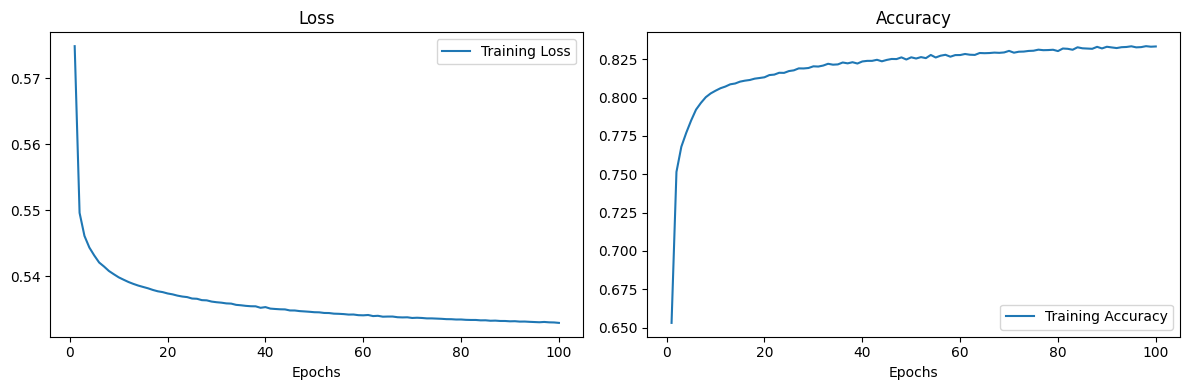

In [31]:
try:
	# se specificato, carica i pesi (se trovati)
	if LOAD_WEIGHTS:
		autoencoder.load_weights(path_weights)
		print("Loaded weights for CONVOLUTIONAL")
	else:
		raise Exception
except Exception as e:
	print(f"Loading CONVOLUTIONAL Error: {e}")
	print("Didn't load weights, training CONVOLUTIONAL")

	# misura tempo di training
	time_start = time.time()
	# training
	history = autoencoder.fit(ds_preprocessed, ds_preprocessed, epochs=N_EPOCHS, batch_size=BATCH_SIZE, shuffle=True)
	time_end = time.time()

	# se specificato, salva i tempi e i pesi
	if(SAVE_TIMES):
		with open(PATH_TIMES, "a") as f:
			f.write(f"conv\t{N_EPOCHS}\t{BATCH_SIZE}\t{FILTERS}\t{LEARNING_RATE}\t: {time_end - time_start}s\n")
	print(f"Training time: {time_end - time_start} seconds")  # Print the time taken by the fit function
	if LOAD_WEIGHTS:
		autoencoder.save_weights(path_weights)
	print("Training done, weights saved")

	# grafici history
	plot_training_history(history, N_EPOCHS, name=f"conv{plot_params}_history")


Esegui e trova le anomalie, come le 40 immagini con errore maggiore (con scarto quadratico medio, applicato sulle immagini ricostruite dall'autoencoder e flattened):

1872/1872 [==============================] - 4s 2ms/step


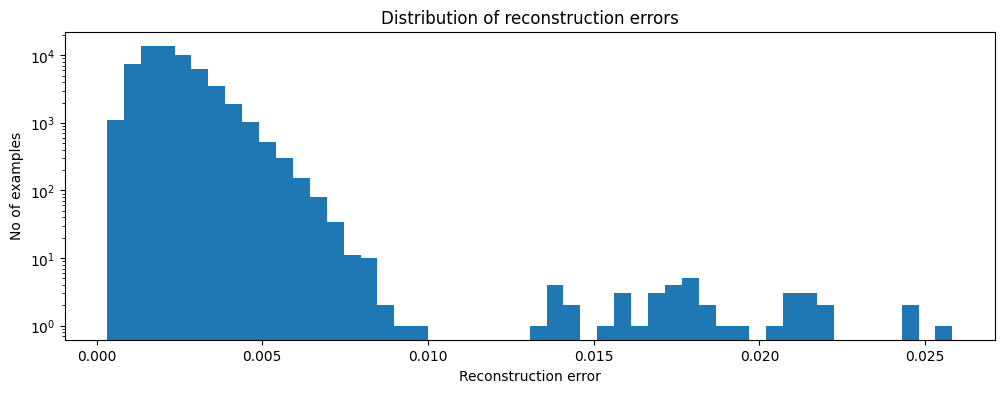

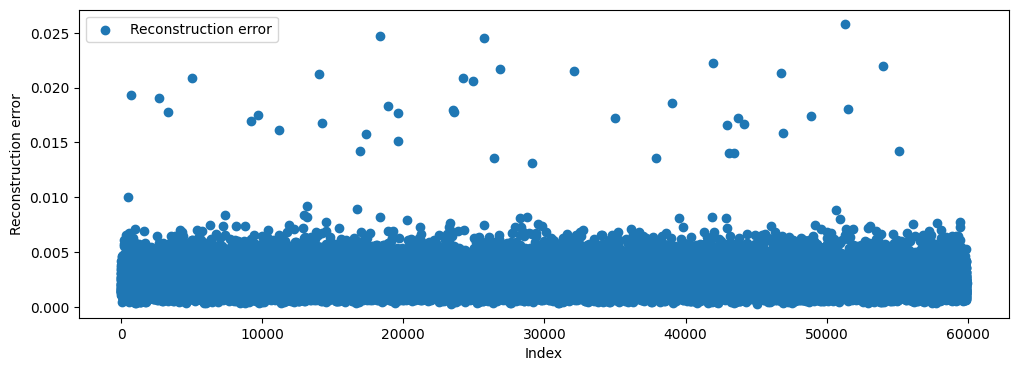

In [32]:
# ricostruisci il dataset con l'autoencoder
ds_reconstructed = autoencoder.predict(ds_preprocessed)

# appiattisci dataset originale e ricostruito, per confrontarli
ds_flat = ds_preprocessed.reshape(ds_preprocessed.shape[0], -1)
ds_reconstructed_flat = ds_reconstructed.reshape(ds_reconstructed.shape[0], -1)

# calcola errore di ricostruzione (mse) per ogni immagine
error_reconstruction = np.array([mean_squared_error(ds_flat[i], ds_reconstructed_flat[i]) for i in range(ds_flat.shape[0])])

# grafici errore
error_reconstruction_flat = error_reconstruction.flatten()
plot_hist_err_reconstruction(error_reconstruction_flat, name=f"conv{N_EPOCHS}_{BATCH_SIZE}_{FILTERS[0]}_{FILTERS[1]}_hist")
plot_scatter_err_reconstruction(error_reconstruction, name=f"conv{N_EPOCHS}_{BATCH_SIZE}_{FILTERS[0]}_{FILTERS[1]}_scatter")

# identifica come anomalie le 40 immagini con errore maggiore
anomalies = error_reconstruction.argsort()[-40:]

Stampa le presunte anomalie (riordinate):

[736, 2707, 3312, 5021, 9207, 9715, 11168, 14036, 14259, 16931, 17364, 18334, 18892, 19631, 19644, 23535, 23600, 24255, 24909, 25745, 26457, 26822, 29149, 32072, 35009, 37913, 39043, 41922, 42928, 43068, 43420, 43709, 44140, 46749, 46883, 48914, 51292, 51473, 53959, 55134]


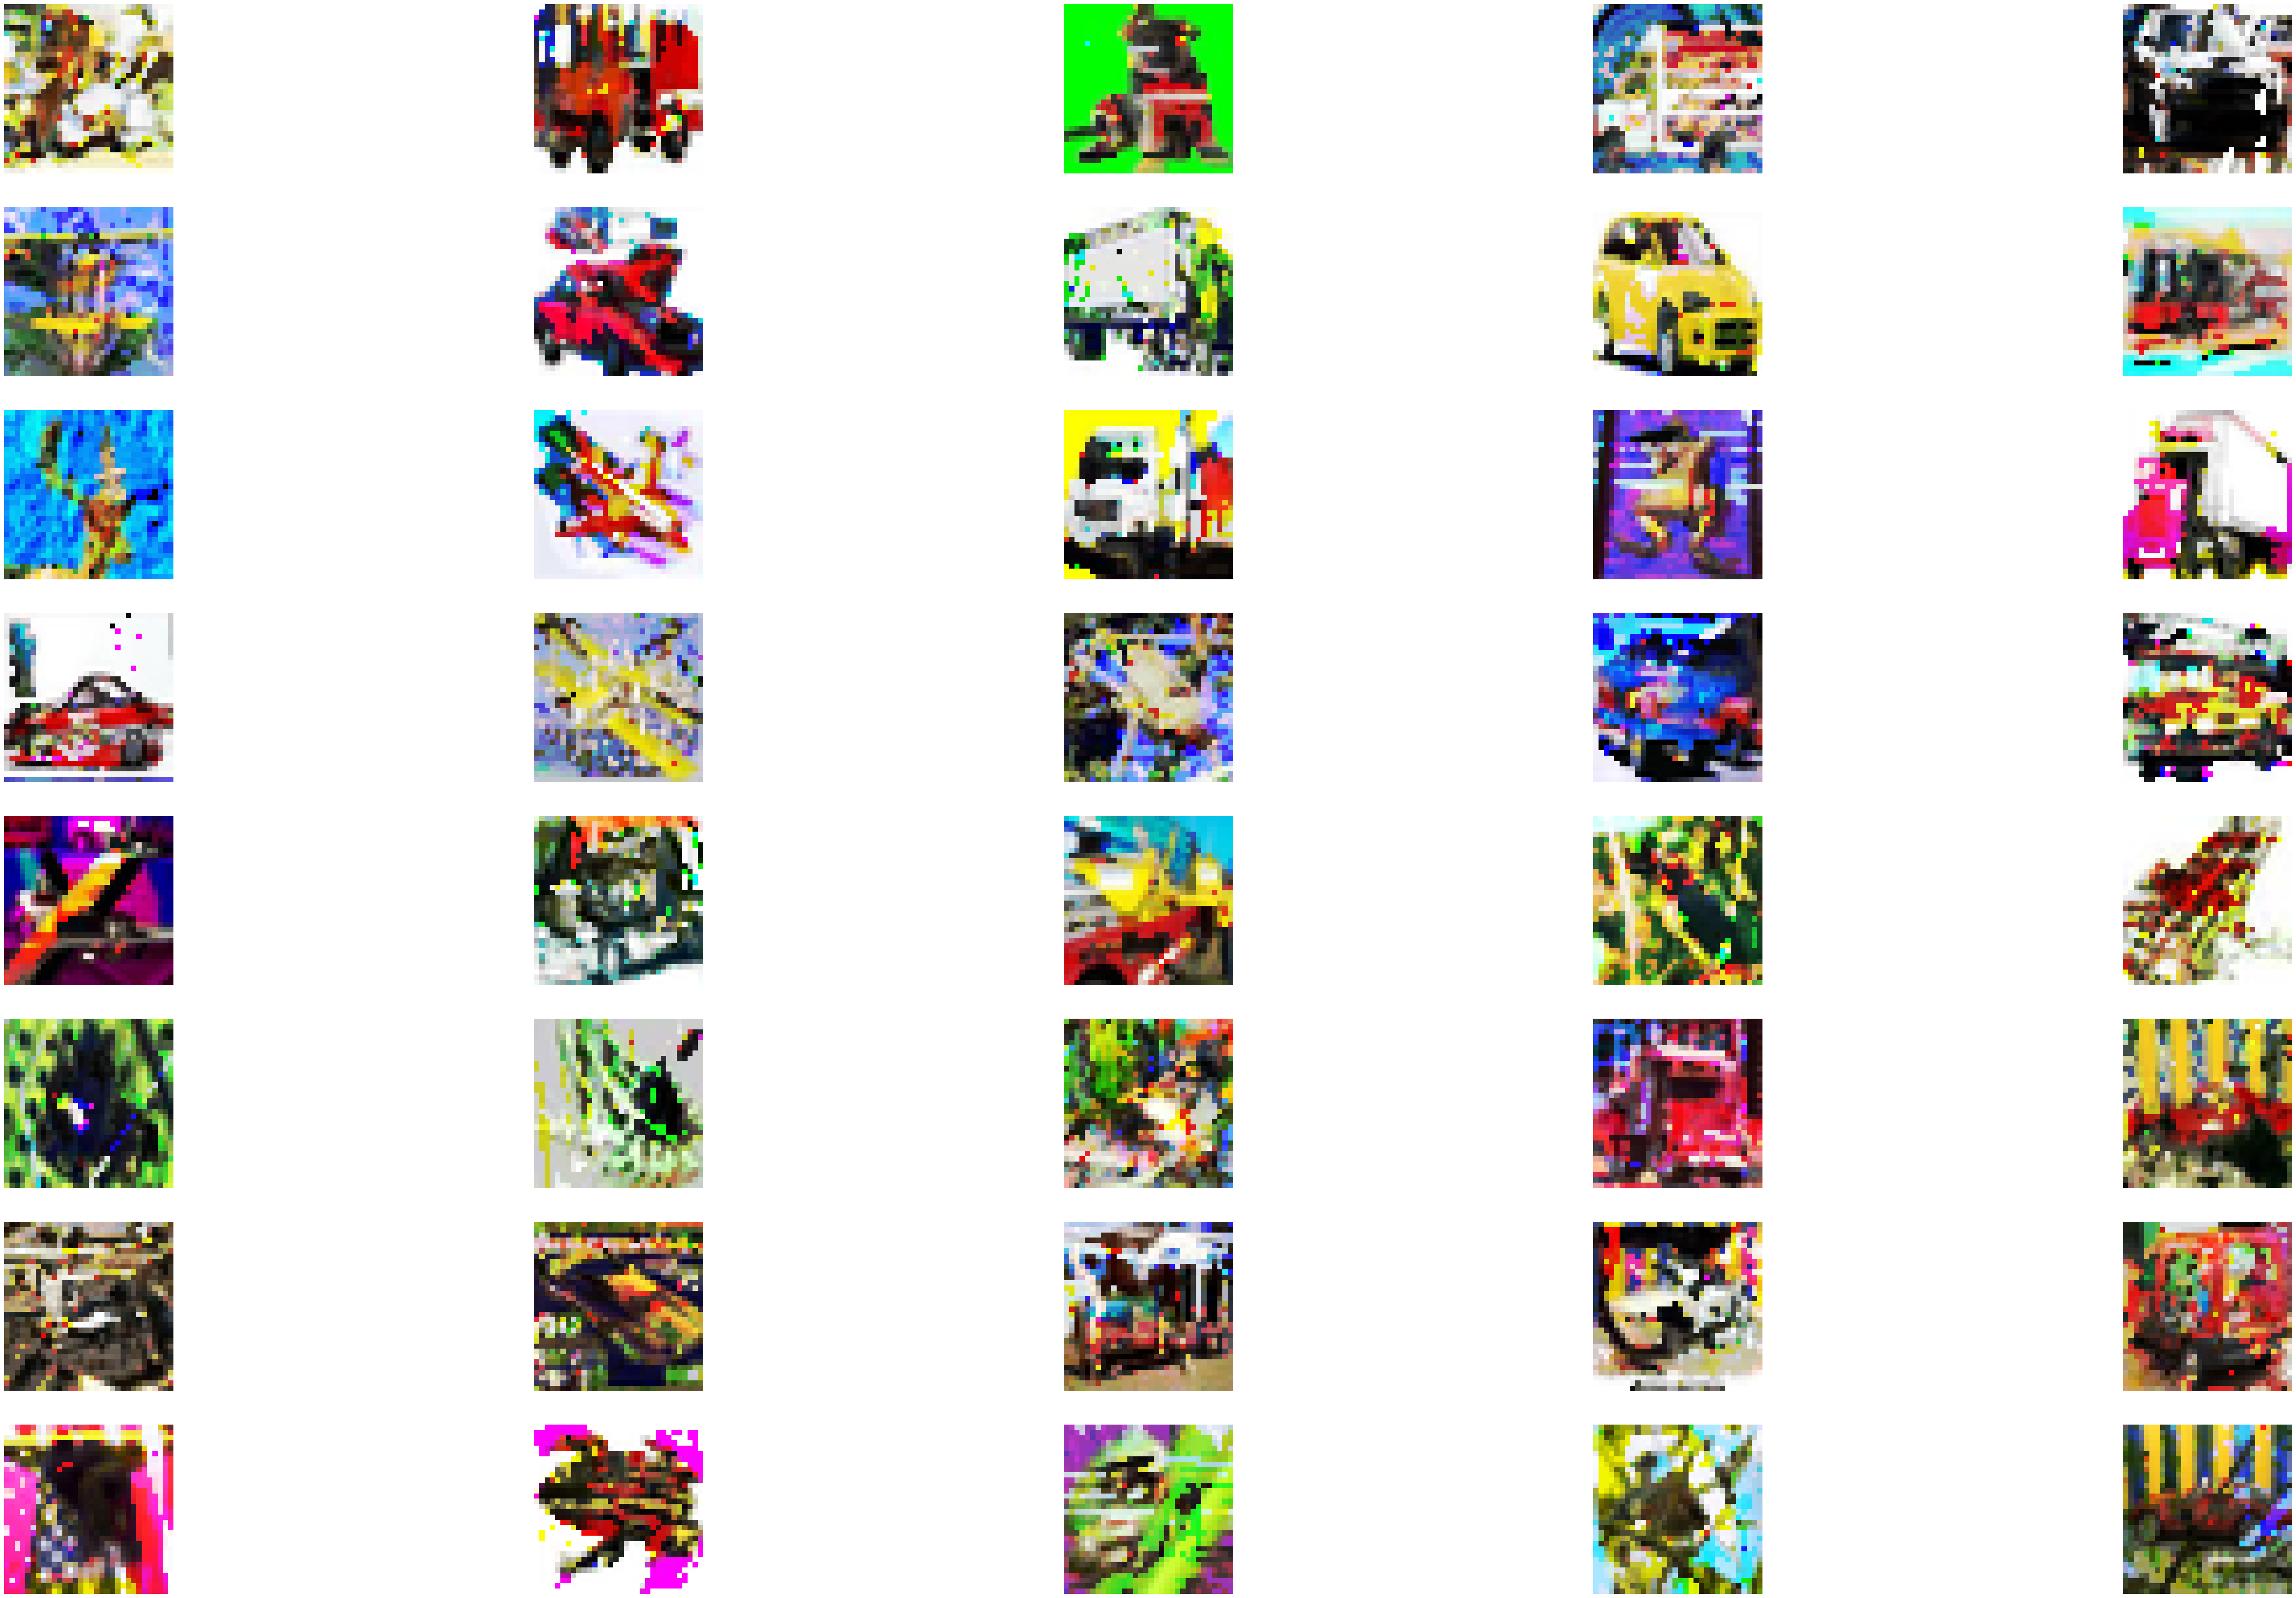

In [33]:
anomalies = sorted(anomalies)
print(anomalies)
anomalies_img = []
for i in anomalies:
	anomalies_img.append(dataset[i])
plot_images(anomalies_img, (8,5), name=f"conv{N_EPOCHS}_{BATCH_SIZE}_{FILTERS[0]}_{FILTERS[1]}")




## Commenti

Si è scelto di usare un autoencoder, essendo uno dei metodi principali per clustering e anomaly detection, in particolare su dati più complessi come delle immagini: sono stati provati sommariamente anche altri modelli, ma autoencoder con semplici strati densi non danno risultati ottimali, non essendo forse adatti a lavorare su immagini, e in particolare gli algoritmi di clustering (dbScan, K-Means, Isolation Forest, One-Class SVM, LOF, elliptic) non sembrano proprio riuscire a distinguere le anomalie.

Le immagini identificate come anomalie fanno ben sperare, poiché sembrano tutte ricoperte da un'interferenza o uno "scarabocchio".  
In più, come si può osservare soprattutto dal grafico scatter, ci sono esattamente 40 immagini che spiccano su tutto il dataset per un maggiore errore di ricostruzione. In realtà ci sono anche altri punti del grafico che sembrano avvicinarcisi, ma dopo aver provato un po' di combinazioni diverse di iperparametri, con gli attuali sembra che l'insieme dei primi 40 sia più staccato dal resto: infatti, con altri iperparametri alcune delle attuali anomalie identificate veniva scambiata con qualche altra con un errore, in quel caso, maggiore (c'è un'altra immagine in particolare che riporta sempre un errore di ricostruzione molto più vicino alle altre anomalie che alla maggioranza, e che ha avuto più difficoltà a distanziarsi da esse).  

Anche le curve di loss e accuracy risultavano meno regolari con altri iperparametri, o costanti, o con un improvviso scatto iniziale, indicando forse un apprendimento troppo rapido.  
Altre combinazioni di parametri, invece, producono risultati quasi equivalenti, ma gli attuali sembrano leggermente migliori per le caretteristiche appena citate: per esempio, darebbe risultati simili raddoppiare il learning rate a 0.001 e dimezzare le epoch a 50 (richiedendo anche la metà del tempo di addestramento), ma il grafico di training sarebbe un po' meno regolare.

### Altri tentativi

Altri tentativi, con grafici di loss/accuracy meno regolari o minore distinzione delle anomalie (sbagliando, a volte, a riconoscerne alcune):
* batch size: più bassa (64/128) ha una history irregolare, essendo forse più soggetta alle anomalie o piccole variazioni; più alta (384) fa salire immediatamente l'accuracy, che poi continua a crescere poco e irregolarmente (e inizia a richiedere troppa memoria);
* meno filtri (16) producono minore loss e accuracy;
* filtri (32,32), (64,64) hanno risultati simili, ma gli attuali sono leggermente migliori per separazione delle anomalie;
* più filtri (128,128 o 64,128), pur avendo una maggiore accuracy/minore loss e riuscendo comunque a riconoscere le stesse anomalie, le separano leggermente meno rispetto ai filtri attuali, e hanno un grafico meno stabile;
* altri strati (dropout, batchNormalization) sembrano peggiorare accuracy e velocità di addestramento e non riconoscono le stesse anomalie delle attuali;
* con meno epoch i risultati ancora non sono ottimali, e di più aumentano di poco l'accuracy ma distinguono peggio le 40 anomalie di questo specifico caso.

## Dati personali
Daniele D'Ugo - 0001027741